<a href="https://colab.research.google.com/github/Danil1D/KSVD/blob/main/%D0%94%D0%B0%D1%88%D0%BA%D0%B5%D0%B2%D0%B8%D1%87_%D0%9B%D0%B0%D0%B1_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch [1/10], Loss: 0.0596
Epoch [2/10], Loss: 0.0337
Epoch [3/10], Loss: 0.0279
Epoch [4/10], Loss: 0.0253
Epoch [5/10], Loss: 0.0238
Epoch [6/10], Loss: 0.0224
Epoch [7/10], Loss: 0.0214
Epoch [8/10], Loss: 0.0207
Epoch [9/10], Loss: 0.0201
Epoch [10/10], Loss: 0.0196


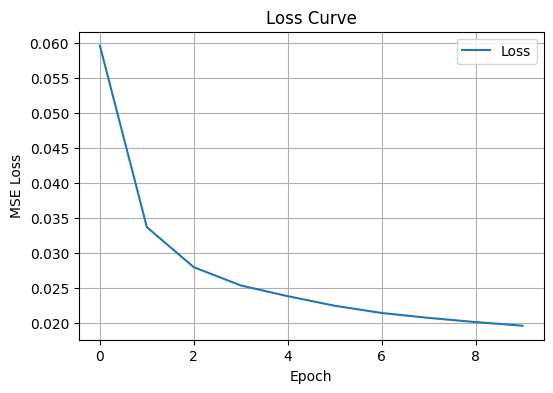

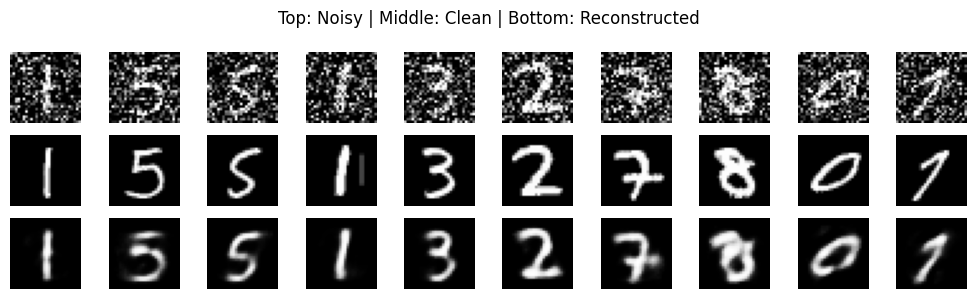

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_noisy = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.5 * torch.randn_like(x)),
    transforms.Lambda(lambda x: torch.clamp(x, 0., 1.))
])
transform_clean = transforms.ToTensor()

noisy_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_noisy)
clean_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_clean)

class NoisyMNISTDataset(Dataset):
    def __init__(self, noisy_dataset, clean_dataset):
        self.noisy_dataset = noisy_dataset
        self.clean_dataset = clean_dataset

    def __len__(self):
        return len(self.noisy_dataset)

    def __getitem__(self, idx):
        noisy_img, _ = self.noisy_dataset[idx]
        clean_img, _ = self.clean_dataset[idx]
        return noisy_img, clean_img

train_dataset = NoisyMNISTDataset(noisy_dataset, clean_dataset)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

losses = []
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs = noisy_imgs.to(device)
        clean_imgs = clean_imgs.to(device)

        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

plt.figure(figsize=(6,4))
plt.plot(losses, label='Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

def show_images(noisy, clean, output, n=10):
    plt.figure(figsize=(n, 3))
    for i in range(n):
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.subplot(3, n, n + i + 1)
        plt.imshow(clean[i].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.subplot(3, n, 2*n + i + 1)
        plt.imshow(output[i].squeeze().detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle("Top: Noisy | Middle: Clean | Bottom: Reconstructed")
    plt.tight_layout()
    plt.show()

sample_noisy, sample_clean = next(iter(train_loader))
sample_noisy = sample_noisy.to(device)
sample_clean = sample_clean.to(device)
model.eval()
with torch.no_grad():
    reconstructed = model(sample_noisy)

show_images(sample_noisy, sample_clean, reconstructed)
